In [14]:
import pandas as pd
import os

# List of files
files = [
    "Data/olist_orders_dataset.csv",
    "Data/olist_products_dataset.csv",
    "Data/olist_sellers_dataset.csv",
    "Data/product_category_name_translation.csv",
    "Data/olist_geolocation_dataset.csv",
    "Data/olist_order_items_dataset.csv",
    "Data/olist_order_payments_dataset.csv",
    "Data/olist_order_reviews_dataset.csv",
    "Data/olist_customers_dataset.csv"
]

data = {}
for file in files:
    try:
        df = pd.read_csv(file)
        data[file] = df
        print(f"--- {file} ---")
        print(df.info())
        print(df.head())
        print("\n")
    except Exception as e:
        print(f"Error reading {file}: {e}")

--- Data/olist_orders_dataset.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   


C:\Users\ch061\AppData\Local\Temp\ipykernel_17892\1910845161.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_score', y='freight_ratio', data=filtered_data, palette='Reds')


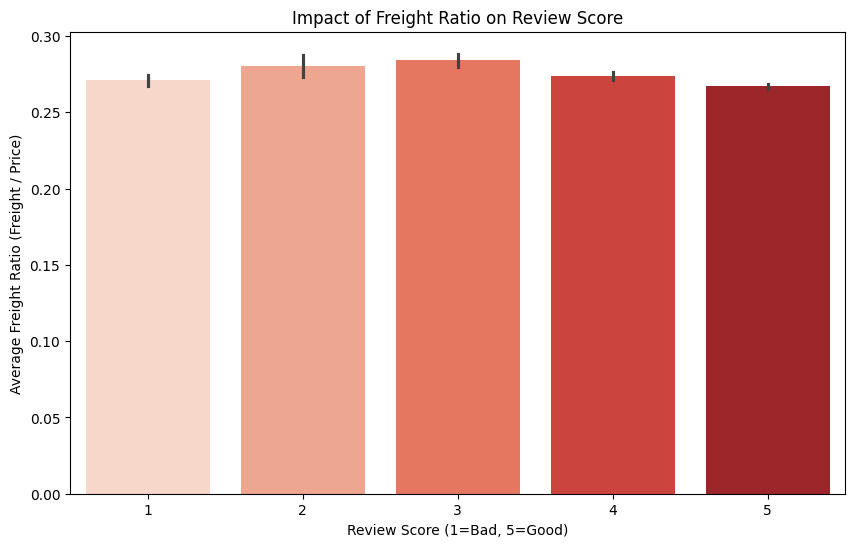

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 (가정)
order_items = pd.read_csv('Data/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')

# 1. 주문 건별 '총 상품 가격'과 '총 배송비' 계산
order_freight = order_items.groupby('order_id')[['price', 'freight_value']].sum().reset_index()

# 2. '배송비 비율(Freight Ratio)' 계산
# 예: 100원짜리에 배송비 10원이면 0.1 (10%)
order_freight['freight_ratio'] = order_freight['freight_value'] / order_freight['price']

# 3. 리뷰 데이터와 결합
merged = pd.merge(order_freight, order_reviews[['order_id', 'review_score']], on='order_id')

# 4. 아웃라이어 제거 (비율이 너무 비정상적으로 높은 경우 제외, 시각화 가독성 위해)
filtered_data = merged[merged['freight_ratio'] < 1.0] # 배송비가 물건값보다 비싼 경우 제외(혹은 포함 가능)

# 5. 시각화: 리뷰 점수별 배송비 비율 분포
plt.figure(figsize=(10, 6))
sns.barplot(x='review_score', y='freight_ratio', data=filtered_data, palette='Reds')
plt.title('Impact of Freight Ratio on Review Score')
plt.xlabel('Review Score (1=Bad, 5=Good)')
plt.ylabel('Average Freight Ratio (Freight / Price)')
plt.show()

In [25]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# 1. 데이터 로드 (파일 경로에 맞게 수정하세요)
customers = pd.read_csv('Data/olist_customers_dataset.csv')
geo = pd.read_csv('Data/olist_geolocation_dataset.csv')

# 2. 전처리: 우편번호(Zip Code)별로 위도/경도 평균 구하기 (중복 제거)
# 이 과정이 없으면 데이터가 너무 커서 렉이 걸립니다.
geo_agg = geo.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# 3. 데이터 병합: 고객 데이터에 위도/경도 붙이기
# customers의 'customer_zip_code_prefix'와 geo의 'geolocation_zip_code_prefix'를 기준으로 합칩니다.
df_map = pd.merge(customers, geo_agg, 
                  left_on='customer_zip_code_prefix', 
                  right_on='geolocation_zip_code_prefix', 
                  how='left')

# 위도/경도가 없는 데이터(NaN) 제거
df_map = df_map.dropna(subset=['geolocation_lat', 'geolocation_lng'])

# 4. 지도 그리기
# 브라질의 대략적인 중심 좌표(-14.2, -51.9)로 지도를 엽니다.
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# 히트맵 데이터 준비 (위도, 경도 리스트)
# 데이터가 너무 많으면 렌더링이 오래 걸리므로 샘플링(1만 개)해서 그려봅니다.
heat_data = df_map[['geolocation_lat', 'geolocation_lng']].sample(10000).values.tolist()

# 지도에 히트맵 추가
HeatMap(heat_data, radius=15).add_to(m)

# 5. 지도 저장 및 확인
m.save('brazil_customer_heatmap.html')
print("지도가 'brazil_customer_heatmap.html' 파일로 저장되었습니다. 파일을 열어보세요!")
m # 주피터 노트북이라면 바로 보입니다.

지도가 'brazil_customer_heatmap.html' 파일로 저장되었습니다. 파일을 열어보세요!


In [2]:
import pandas as pd
import folium

# 1. 데이터 로드
orders = pd.read_csv('Data/olist_orders_dataset.csv')
items = pd.read_csv('Data/olist_order_items_dataset.csv')
customers = pd.read_csv('Data/olist_customers_dataset.csv')
sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
geo = pd.read_csv('Data/olist_geolocation_dataset.csv')

# 2. 좌표 데이터 중복 제거 (우편번호별 평균 좌표)
geo_agg = geo.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',   # 위도 -> 평균
    'geolocation_lng': 'mean',   # 경도 -> 평균
    'geolocation_city': 'first', # 도시 이름 -> 첫 번째 값 유지
    'geolocation_state': 'first' # 주 이름 -> 첫 번째 값 유지
}).reset_index()

# 3. 데이터 대통합 (Join Hell 시작!)
# (1) 주문 상세 + 주문 정보
df = pd.merge(items, orders, on='order_id')
# (2) + 판매자 정보 (출발지 우편번호 확보)
df = pd.merge(df, sellers, on='seller_id')
# (3) + 고객 정보 (도착지 우편번호 확보)
df = pd.merge(df, customers, on='customer_id')

# 4. 좌표 매핑 (가장 중요한 단계)
# 판매자 좌표 붙이기 (Suffix '_seller'로 구분)
df = pd.merge(df, geo_agg, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df.rename(columns={'geolocation_lat': 'lat_seller', 'geolocation_lng': 'lng_seller'}, inplace=True)

# 고객 좌표 붙이기 (Suffix '_customer'로 구분)
df = pd.merge(df, geo_agg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df.rename(columns={'geolocation_lat': 'lat_cust', 'geolocation_lng': 'lng_cust'}, inplace=True)

# 좌표 없는 데이터 제거
df = df.dropna(subset=['lat_seller', 'lng_seller', 'lat_cust', 'lng_cust'])

# 5. 시각화 (Sampling)
# 데이터가 너무 많으므로 3000개만 샘플링해서 그립니다.
df_sample = df.sample(n=3000, random_state=42)

# 지도 생성 (브라질 중심)
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# 선 긋기 루프
for _, row in df_sample.iterrows():
    # 출발지(Seller) -> 도착지(Customer) 좌표 쌍
    points = [[row['lat_seller'], row['lng_seller']], 
              [row['lat_cust'], row['lng_cust']]]
    
    # 선 그리기
    folium.PolyLine(points, 
                    color="blue",       # 선 색상
                    weight=0.5,         # 선 두께 (얇게 해야 겹쳐서 예쁨)
                    opacity=0.3         # 투명도 (겹칠수록 진해지게)
                   ).add_to(m)

# 6. 저장 및 출력
m.save('brazil_logistics_network.html')
print("물류 네트워크 지도가 'brazil_logistics_network.html'로 저장되었습니다.")
m

물류 네트워크 지도가 'brazil_logistics_network.html'로 저장되었습니다.


In [4]:
import pandas as pd
import folium
import numpy as np

# 1. 데이터 로드 및 전처리 (이전과 동일)
orders = pd.read_csv('Data/olist_orders_dataset.csv')
items = pd.read_csv('Data/olist_order_items_dataset.csv')
customers = pd.read_csv('Data/olist_customers_dataset.csv')
sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
geo = pd.read_csv('Data/olist_geolocation_dataset.csv')

# 좌표 중복 제거
geo_agg = geo.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean', 'geolocation_lng': 'mean'
}).reset_index()

# 데이터 병합
df = pd.merge(items, orders, on='order_id')
df = pd.merge(df, sellers, on='seller_id')
df = pd.merge(df, customers, on='customer_id')

# 좌표 매핑
df = pd.merge(df, geo_agg, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df.rename(columns={'geolocation_lat': 'lat_seller', 'geolocation_lng': 'lng_seller'}, inplace=True)
df = df.drop(columns=['geolocation_zip_code_prefix'])

df = pd.merge(df, geo_agg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df.rename(columns={'geolocation_lat': 'lat_cust', 'geolocation_lng': 'lng_cust'}, inplace=True)
df = df.dropna(subset=['lat_seller', 'lng_seller', 'lat_cust', 'lng_cust'])

# -----------------------------------------------------------
# 여기서부터가 핵심 업그레이드 코드입니다!
# -----------------------------------------------------------

# 2. 거리 계산 함수 (Haversine Formula) - 색깔 구분을 위해 필요
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

df['distance_km'] = haversine(df['lat_seller'], df['lng_seller'], df['lat_cust'], df['lng_cust'])

# 3. 곡선 생성 함수 (Great Circle Path)
# 직선 대신 지구 곡면을 따라가는 점들을 생성해줍니다.
def get_bearing(lat1, lon1, lat2, lon2):
    dLon = np.radians(lon2 - lon1)
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    y = np.sin(dLon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)
    return np.arctan2(y, x)

def get_destination(lat, lon, bearing, dist):
    R = 6371
    lat, lon, bearing = np.radians(lat), np.radians(lon), bearing
    lat2 = np.arcsin(np.sin(lat)*np.cos(dist/R) + np.cos(lat)*np.sin(dist/R)*np.cos(bearing))
    lon2 = lon + np.arctan2(np.sin(bearing)*np.sin(dist/R)*np.cos(lat), np.cos(dist/R)-np.sin(lat)*np.sin(lat2))
    return np.degrees(lat2), np.degrees(lon2)

def get_curve(lat1, lon1, lat2, lon2, n=20):
    dist = haversine(lat1, lon1, lat2, lon2)
    bearing = get_bearing(lat1, lon1, lat2, lon2)
    path = []
    for i in range(n+1):
        d = dist * (i/n)
        path.append(get_destination(lat1, lon1, bearing, d))
    return path

# 4. 지도 그리기 (샘플링 3000개)
df_sample = df.sample(n=3000, random_state=42)
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB dark_matter') 
# 팁: 'CartoDB dark_matter' 스타일을 쓰면 형광색 선이 훨씬 돋보입니다!

# 거리 기준점 설정 (상위 25% 장거리 = 약 800km)
threshold = 800 

for _, row in df_sample.iterrows():
    # 색상 및 스타일 결정
    if row['distance_km'] > threshold:
        color = '#ff4d4d' # 빨간색 (장거리)
        weight = 1.5      # 좀 더 두껍게
        opacity = 0.6     # 좀 더 진하게
        z_index = 2       # 파란선 위에 그리기
    else:
        color = '#3399ff' # 파란색 (단거리)
        weight = 0.5
        opacity = 0.3
        z_index = 1
        
    # 곡선 좌표 생성
    path = get_curve(row['lat_seller'], row['lng_seller'], row['lat_cust'], row['lng_cust'])
    
    # 지도에 추가
    folium.PolyLine(path, color=color, weight=weight, opacity=opacity).add_to(m)

# 5. 저장
m.save('brazil_logistics_curved.html')
print("지도가 완성되었습니다. 'brazil_logistics_curved.html' 파일을 열어보세요!")

지도가 완성되었습니다. 'brazil_logistics_curved.html' 파일을 열어보세요!
